In [95]:
from dotenv import load_dotenv

print(f".env file is loaded: {load_dotenv()}")

.env file is loaded: True


# Intro to Structured Outputs

**Structured Outputs (SO)** is a feature that ensures the model will always generate responses that adhere to your supplied JSON Schema, so you don't need to worry about the model omitting a required key, or hallucinating an invalid enum value.

Some benefits of Structured Outputs include:

1. Reliable type-safety: No need to validate or retry incorrectly formatted responses
2. Explicit refusals: Safety-based model refusals are now programmatically detectable
3. Simpler prompting: No need for strongly worded prompts to achieve consistent formatting

In addition to supporting JSON Schema in the REST API, the OpenAI SDKs for Python and JavaScript also make it easy to define object schemas using **Pydantic**

Invalid data that raises a helpful error

## Structured Outputs: Toy Example

In [100]:
import json
from openai.types.chat import ChatCompletion


def parse_completion(completion: ChatCompletion) -> None:
    output = completion.choices[0].message
    if output.refusal:
        # Handle refusal
        raise RuntimeError(output.refusal)
    elif output.content:
        try:
            output_json = json.loads(output.content)
            return output_json
        except Exception as e:
            # Handle possible exceptions, e.g. invalid JSON
            raise RuntimeError(e)

In [98]:
from pydantic import BaseModel


class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]

In [99]:
CalendarEvent.model_json_schema()

{'properties': {'name': {'title': 'Name', 'type': 'string'},
  'date': {'title': 'Date', 'type': 'string'},
  'participants': {'items': {'type': 'string'},
   'title': 'Participants',
   'type': 'array'}},
 'required': ['name', 'date', 'participants'],
 'title': 'CalendarEvent',
 'type': 'object'}

In [97]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
)

print(completion.choices[0].message.content)

Event: Science Fair  
Date: Friday  
Participants: Alice and Bob


In [103]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
    extra_body={"guided_json": CalendarEvent.model_json_schema()},
)

In [104]:
print(parse_completion(completion))

{'name': 'Going to Science Fair', 'date': 'Friday', 'participants': ['Alice', 'Bob']}


In [105]:
event = CalendarEvent(**parse_completion(completion))

In [109]:
event.date

'Friday'

## Pydantic

**Pydantic** is a Python library for data validation and settings management based on Python's type hints. At its core, it allows you to define how data should be in a clear, Pythonic way.

Think of it as a contract for your data. You define a "shape" for your data using a class, and Pydantic ensures that any incoming data conforms to that shape. If it doesn't, Pydantic raises clear, human-readable errors.

In [110]:
from pydantic import BaseModel
from typing import List


class User(BaseModel):
    id: int
    name: str = "John Doe"
    friends: List[int] = []

In [111]:
import requests

response = requests.get("http://127.0.0.1:8000/user/1")
user = User(**response.json())
print(user)

id=1 name='Jane' friends=[2, 3]


In [112]:
response = requests.get("http://127.0.0.1:8000/user/4")

try:
    User(**response.json())
except Exception as e:
    print(e)

3 validation errors for User
id
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='non-integer', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
name
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
friends
  Input should be a valid list [type=list_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type


# Structured Outputs for Data Extraction

In [48]:
from datasets import load_dataset

dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1")

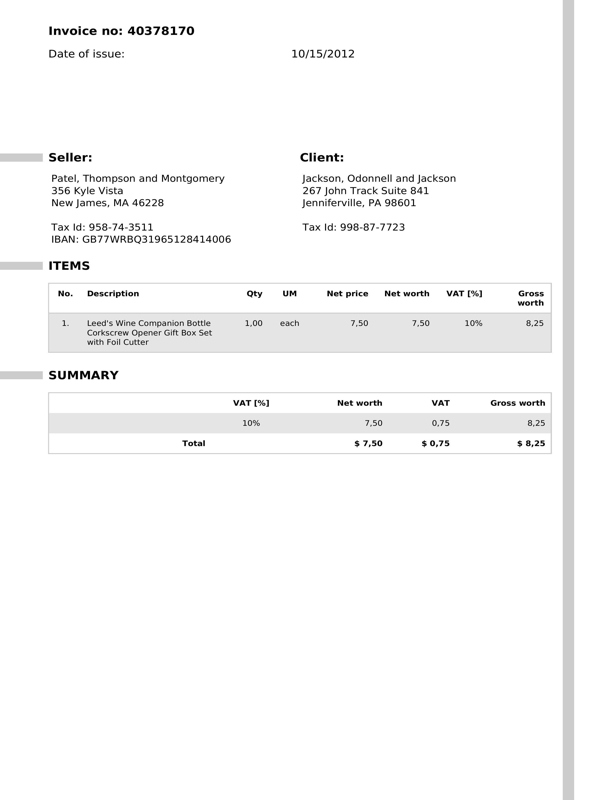

In [113]:
from IPython.display import display

display(dataset["train"][0]["image"].resize((600, 800)))

Define a schema using Pydantic's `BaseModel`

In [114]:
import datetime


class Item(BaseModel):
    item_desc: str
    item_qty: float
    item_net_price: float
    item_net_worth: float
    item_vat: str
    item_gross_worth: float


class Invoice(BaseModel):
    invoice_no: str
    invoice_date: datetime.datetime
    seller: str
    client: str
    seller_tax_id: str
    client_tax_id: str
    iban: str
    items: List[Item]

Add the schema to your request (`extra_body.guided_json`)

In [115]:
import base64
from io import BytesIO


# Function to encode the image
def encode_image(image):
    # Convert PIL image to bytes
    buffer = BytesIO()
    image.save(buffer, format="JPEG")  # or format="PNG" if needed
    image_bytes = buffer.getvalue()

    # Encode to base64
    return base64.b64encode(image_bytes).decode("utf-8")


base64_image = encode_image(dataset["train"][0]["image"].resize((600, 800)))

In [116]:
extraction_system_prompt = """You are a helpful assistant for data extraction from invoices. 
You'll be given an invoice and your task is to exract data from it according to the JSON schema."""

extraction_generation_prompt = "Please extract the invoice data from the attached image according to the provided JSON schema."

In [117]:
client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-VL-72B-Instruct",
    messages=[
        {"role": "system", "content": extraction_system_prompt},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": extraction_generation_prompt,
                },
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
            ],
        },
    ],
    extra_body={"guided_json": Invoice.model_json_schema()},
)

In [118]:
from pprint import pprint

pprint(parse_completion(completion))

{'client': 'Jackson, Odonnell and Jackson',
 'client_tax_id': '998-87-7723',
 'iban': 'GB77WRBQ31965128414006',
 'invoice_date': '2012-10-15T00:00:00Z',
 'invoice_no': '40378170',
 'items': [{'item_desc': "Leed's Wine Companion Bottle Corkscrew Opener Gift "
                         'Box Set with Foil Cutter',
            'item_gross_worth': 8.25,
            'item_net_price': 7.5,
            'item_net_worth': 7.5,
            'item_qty': 1,
            'item_vat': '10%'}],
 'seller': 'Patel, Thompson and Montgomery',
 'seller_tax_id': '958-74-3511'}


# Structured Outputs for RAG Metadata Generation

## 1. Import Haystack components

In [119]:
from haystack import Pipeline
from haystack.components.embedders import (
    SentenceTransformersDocumentEmbedder,
    SentenceTransformersTextEmbedder,
)
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.dataclasses import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

## 2. Prepare documents

### TechCrunch Articles

**Notice: The following data is generated via o3 by OpenAI, it can contain hallucinations, but it is not the case for this tutorial.**

In [120]:
documents = [
    # Data for May
    Document(
        content="Google quietly released an app that lets you download and run AI models locally",
        meta={
            "date": "31-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/31/google-quietly-released-an-app-that-lets-you-download-and-run-ai-models-locally/",
        },
    ),
    Document(
        content="Left-leaning influencers embrace Bluesky without abandoning X, Pew says",
        meta={
            "date": "31-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/31/left-leaning-influencers-embrace-bluesky-without-abandoning-x-pew-says/",
        },
    ),
    Document(
        content="NAACP calls on Memphis officials to halt operations at xAI’s ‘dirty data center’",
        meta={
            "date": "31-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/31/naacp-calls-on-officials-to-halt-operations-at-xais-dirty-data-center-in-memphis/",
        },
    ),
    Document(
        content="Report: Elon Musk’s drug use ramped up during the 2024 presidential campaign",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/report-elon-musks-drug-use-ramped-up-during-the-2024-presidential-campaign/",
        },
    ),
    Document(
        content="It’s not your imagination: AI is speeding up the pace of change",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/its-not-your-imagination-ai-is-speeding-up-the-pace-of-change/",
        },
    ),
    Document(
        content=(
            "TechCrunch Mobility: A ride-sharing pioneer comes for Uber, "
            "Tesla loses more ground, and dog-like delivery robots land in Texas"
        ),
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/techcrunch-mobility-a-ride-sharing-pioneer-comes-for-uber-tesla-loses-more-ground-and-dog-like-delivery-robots-land-in-texas/",
        },
    ),
    Document(
        content="Trump administration to claw back $3.7B in clean energy and manufacturing awards",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/trump-administration-to-claw-back-3-7b-in-clean-energy-and-manufacturing-awards/",
        },
    ),
    Document(
        content="Automattic says it will start contributing to WordPress again after pause",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/automattic-says-it-will-start-contributing-to-wordpress-again-after-pause/",
        },
    ),
    Document(
        content="Perplexity’s new tool can generate spreadsheets, dashboards, and more",
        meta={
            "date": "29-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/29/perplexitys-new-tool-can-generate-spreadsheets-dashboards-and-more/",
        },
    ),
    Document(
        content="Delaware attorney general reportedly hires a bank to evaluate OpenAI’s restructuring plan",
        meta={
            "date": "29-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/29/delaware-attorney-general-reportedly-hires-a-bank-to-evaluate-openais-restructuring-plan/",
        },
    ),
    # Data for April
    Document(
        content="Microsoft’s most capable new Phi 4 AI model rivals the performance of far larger systems",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/",
        },
    ),
    Document(
        content="Sam Altman’s World unveils a mobile verification device",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/sam-altmans-world-unveils-a-mobile-verification-device/",
        },
    ),
    Document(
        content="Epic Games just scored a major win against Apple",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/epic-games-just-scored-a-major-win-against-apple/",
        },
    ),
    Document(
        content="Amazon launches Nova Premier, its most capable AI model yet",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/",
        },
    ),
    Document(
        content="Meta forecasted it would make $1.4 T in revenue from generative AI by 2035",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/meta-forecasted-it-would-make-1-4t-in-revenue-from-generative-ai-by-2035/",
        },
    ),
    Document(
        content="Google’s Gemini chatbot gets upgraded image-creation tools",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/googles-gemini-chatbot-gets-upgraded-image-creation-tools/",
        },
    ),
    Document(
        content="Visa and Mastercard unveil AI-powered shopping",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/visa-and-mastercard-unveil-ai-powered-shopping/",
        },
    ),
    Document(
        content="Musk’s xAI Holdings is reportedly raising the second-largest private funding round ever",
        meta={
            "date": "25-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/25/musks-xai-holdings-is-reportedly-raising-the-second-largest-private-funding-round-ever/",
        },
    ),
    Document(
        content="Noxtua raises $92 M for its sovereign AI tuned for the German legal system",
        meta={
            "date": "22-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/22/noxtua-raises-92m-for-its-sovereign-ai-tuned-for-the-german-legal-system/",
        },
    ),
    Document(
        content="ChatGPT adoption skyrockets in India, but monetization may be trailing",
        meta={
            "date": "04-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/04/chatgpt-adoption-skyrockets-in-india-but-monetization-may-be-trailing/",
        },
    ),
]

### OpenAI Research Blog

**Notice: The following data is generated via o3 by OpenAI, it can contain hallucinations, but it is not the case for this tutorial.**

In [121]:
documents += [
    Document(
        content="Addendum to OpenAI o3 and o4-mini system card: OpenAI o3 Operator",
        meta={
            "date": "23-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/o3-o4-mini-system-card-addendum-operator-o3",
        },
    ),  # :contentReference[oaicite:0]{index=0}
    Document(
        content="Introducing Codex",
        meta={
            "date": "16-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/introducing-codex/",
        },
    ),  # :contentReference[oaicite:1]{index=1}
    Document(
        content="Addendum to o3 and o4-mini system card: Codex",
        meta={
            "date": "16-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/o3-o4-mini-codex-system-card-addendum/",
        },
    ),  # :contentReference[oaicite:2]{index=2}
    Document(
        content="Introducing HealthBench",
        meta={
            "date": "12-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/healthbench/",
        },
    ),  # :contentReference[oaicite:3]{index=3}
    Document(
        content="Thinking with images",
        meta={
            "date": "16-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/thinking-with-images/",
        },
    ),  # :contentReference[oaicite:4]{index=4}
    Document(
        content="OpenAI o3 and o4-mini System Card",
        meta={
            "date": "16-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/o3-o4-mini-system-card/",
        },
    ),  # :contentReference[oaicite:5]{index=5}
    Document(
        content="Introducing OpenAI o3 and o4-mini",
        meta={
            "date": "16-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/introducing-o3-and-o4-mini/",
        },
    ),  # :contentReference[oaicite:6]{index=6}
    Document(
        content="Our updated Preparedness Framework",
        meta={
            "date": "15-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/updating-our-preparedness-framework/",
        },
    ),  # :contentReference[oaicite:7]{index=7}
    Document(
        content="Introducing GPT-4.1 in the API",
        meta={
            "date": "14-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/gpt-4-1/",
        },
    ),  # :contentReference[oaicite:8]{index=8}
    Document(
        content="BrowseComp: a benchmark for browsing agents",
        meta={
            "date": "10-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/browsecomp/",
        },
    ),  # :contentReference[oaicite:9]{index=9}
]

## 3. Creating InMemoryDocumentStore

Let's set up a document indexing pipeline using an in-memory document store and a sentence transformer embedder.
It embeds documents into vector representations and writes them to the store, enabling efficient similarity search.
The pipeline is then run to process and store the provided documents.

In [122]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    "embedder",
    SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"),
)
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")

# Run the indexing pipeline
indexing_pipeline.run({"embedder": {"documents": documents}})

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


{'writer': {'documents_written': 30}}

## 4. Define QueryMetadata Structure 

In [123]:
from typing import Literal
from pydantic import Field, BaseModel


class QueryMetadata(BaseModel):
    start_date: str = Field(
        None,
        description=(
            "The start date of a potential time range, extracted from the user's query. The format should be DD-MM-YYYY."
        ),
    )
    end_date: str = Field(
        description=(
            "The end date of a potential time range, extracted from the user's query. The format should be DD-MM-YYYY."
        ),
    )
    source: Literal["tech_crunch", "openai_blog"]

In [124]:
metadata_system_prompt = """
You are an information extraction system that analyzes natural language queries and extracts metadata in a specific JSON format.

Your task is to extract the following metadata fields:
- start_date: string in "DD-MM-YYYY" format (e.g., "01-01-2024")
- end_date: string in "DD-MM-YYYY" format (e.g., "31-12-2024")
- source: one of ["tech_crunch", "openai_blog"]

Rules:
- If a field is not present in the query, set its value to null.
- Use only the allowed values for 'source'.
- Always return only a valid JSON object. Do not include any explanation or extra text.
"""

metadata_generation_prompt = "User Query: {query}\n\nExtract the metadata as specified."

In [125]:
def generate_query_metadata(query: str) -> dict[str, any]:
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=[
            {"role": "system", "content": metadata_system_prompt},
            {
                "role": "user",
                "content": metadata_generation_prompt.format(query=query),
            },
        ],
        temperature=0.0,
        extra_body={"guided_json": QueryMetadata.model_json_schema()},
    )

    parsed_metadata = parse_completion(completion)

    return parsed_metadata

In [126]:
query = "Find me top 3 TechCrunch articles from April 2025"

print(metadata_generation_prompt.format(query=query) + "\n")
print(generate_query_metadata(query))

User Query: Find me top 3 TechCrunch articles from April 2025

Extract the metadata as specified.

{'start_date': '01-04-2025', 'end_date': '30-04-2025', 'source': 'tech_crunch'}


## 5. Define the RAG Pipeline with Structured Output
This is where we'll build the main pipeline that uses the LLM to generate
structured metadata from the user's query and then uses that metadata to
filter the documents during the search operation.

The prompt template instructs the LLM to extract the metadata and provides
the JSON schema for the output. This is crucial for getting the structured output.

### Prepare filters

In [127]:
def prepare_filters(extracted_metadata: dict[str, any]):
    filters = {}
    conditions = []

    if extracted_metadata["source"]:
        conditions.append(
            {
                "field": "source",
                "operator": "==",
                "value": extracted_metadata["source"],
            }
        )

    if extracted_metadata["start_date"] and extracted_metadata["end_date"]:
        conditions.append(
            {
                "field": "date",
                "operator": ">=",
                "value": extracted_metadata["start_date"],
            }
        )
        conditions.append(
            {
                "field": "date",
                "operator": "<=",
                "value": extracted_metadata["end_date"],
            }
        )
    elif extracted_metadata["start_date"]:
        conditions.append(
            {
                "field": "date",
                "operator": ">=",
                "value": extracted_metadata["start_date"],
            }
        )
    elif extracted_metadata["end_date"]:
        conditions.append(
            {
                "field": "date",
                "operator": "<=",
                "value": extracted_metadata["end_date"],
            }
        )

    if conditions:
        filters = {"operator": "AND", "conditions": conditions}

    return filters

### Pipeline

In [128]:
def run_query(query: str):
    """
    This function runs the RAG pipeline for a given query.
    It first generates the structured metadata and then uses it to retrieve documents.
    """
    print(f"Running query: '{query}'")

    extracted_metadata = generate_query_metadata(query)

    print("[1] Extracted Metadata:\n")
    print(extracted_metadata)

    print("2] Prepare Filters and Run Query:\n")
    filters = prepare_filters(extracted_metadata=extracted_metadata)

    text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
    retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=3, filters=filters)

    retrieval_pipeline = Pipeline()
    retrieval_pipeline.add_component("text_embedder", text_embedder)
    retrieval_pipeline.add_component("retriever", retriever)
    retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

    retrieval_result = retrieval_pipeline.run({"text_embedder": {"text": query}})

    print("\n[3] Retrieved Documents:")
    for doc in retrieval_result["retriever"]["documents"]:
        print(f"  - {doc.content} (Source: {doc.meta['source']}, " f"Date: {doc.meta['date']})")

In [131]:
query = "Find me 3 oldest TechCrunch articles from April 2025"

run_query(query)

Running query: 'Find me 3 oldest TechCrunch articles from April 2025'
[1] Extracted Metadata:

{'start_date': '01-04-2025', 'end_date': '30-04-2025', 'source': 'tech_crunch'}
2] Prepare Filters and Run Query:



Batches: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


[3] Retrieved Documents:
  - Meta forecasted it would make $1.4 T in revenue from generative AI by 2035 (Source: tech_crunch, Date: 30-04-2025)
  - Microsoft’s most capable new Phi 4 AI model rivals the performance of far larger systems (Source: tech_crunch, Date: 30-04-2025)
  - Amazon launches Nova Premier, its most capable AI model yet (Source: tech_crunch, Date: 30-04-2025)


In [74]:
query = "Find me 3 latest articles from OpenAI's Research blog"

# run_query(query)

# SO + Chain of Thought 

In [134]:
from pydantic import Field, BaseModel
from typing import List


class AnswerSchema(BaseModel):
    step_by_step_analysis: str = Field(
        description="Detailed step-by-step analysis of the answer with at least 5 steps and at least 150 words. Always do this step exactly as prompted."
    )

    reasoning_summary: str = Field(description="Concise summary of the step-by-step reasoning process. Around 50 words.")

    relevant_chunks: List[int] = Field(
        description="""
            List of page chunks containing information directly used to answer the question. Include only:
            - Chunk with direct answers or explicit statements
            - Chunks with key information that strongly supports the answer
            Do not include chunks with only tangentially related information or weak connections to the answer.
            At least one chunk should be included in the list.
        """
    )

    final_answer: str

In [135]:
from pathlib import Path
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()

pipeline = Pipeline()
pipeline.add_component("converter", HTMLToDocument())
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=3))
pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipeline.add_component("writer", DocumentWriter(document_store=document_store))
pipeline.connect("converter", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")

pipeline.run({"converter": {"sources": [Path("./data/How much do language models memorize?.html")]}})

No abbreviations file found for en. Using default abbreviations.


Batches: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


{'writer': {'documents_written': 71}}

In [136]:
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=10)

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("text_embedder", text_embedder)
retrieval_pipeline.add_component("retriever", retriever)
retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])

In [137]:
query = """
How do models define, measure, and differentiate between intended and unintended memorisation?
"""

retrieval_result = retrieval_pipeline.run({"text_embedder": {"text": query}})

Batches: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


In [138]:
strs = ""

for doc in retrieval_result["retriever"]["documents"]:
    strs += f"Chunk: {doc.meta['split_id']}, Content: {doc.content}\n"

In [140]:
print(strs)

Chunk: 27, Content: Hence, we can define unintended memorization as
and then the generalization (or intended memorization) must be
Now that we have defined our notions of intended and unintended memorization we turn our attention to practically measuring them. Let us first state a proposition that enables measurement of unintended memorization:
Proposition 1 (Super-additivity of Unintended Memorization).
Assume is a dataset of i.i.d. 
Chunk: 26, Content: To understand how much information about is stored in , we can use the notion of mutual information:
Note that this captures all the information about that is stored in . As we discussed, we need our notion of memorization to account for generalization as well. So when measuring unintended memorization, we are only interested in the information that is present in , which is the uncertainty left in after fixing . 
Chunk: 18, Content: Our notion of unintended memorization must be distinct from intended memorization, which we refer to as 

In [141]:
system_prompt = "You're a helpful AI assistant that answers questions about a scintific paper based on RAG chunks given to you. Always think steb-by-step before answering and follow the schema you are given."

In [142]:
def generate_answer(query: str, context: str) -> dict[str, any]:
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": f"Answer this question {query} based on these data points: {context}",
            },
        ],
        temperature=0.0,
        extra_body={"guided_json": AnswerSchema.model_json_schema()},
    )

    parsed_answer = parse_completion(completion)

    return parsed_answer

In [143]:
query = """
How do models define, measure, and differentiate between intended and unintended memorisation?
"""

parsed_answer = generate_answer(query, strs)

In [144]:
parsed_answer

{'step_by_step_analysis': "To answer the question 'How do models define, measure, and differentiate between intended and unintended memorisation? ', let's break down the information provided in the chunks step-by-step:",
 'reasoning_summary': "1. **Definition of Memorization**: Models store information from the training dataset during the training process. The key challenge is to distinguish between intended memorization (generalization) and unintended memorization.\n2. **Separation from Generalization**: Intended memorization, or generalization, refers to the model's ability to learn patterns and apply them to new, unseen data. Unintended memorization, on the other hand, involves the model retaining specific details from the training data that are not part of the broader patterns.\n3. **Mutual Information**: One approach to measuring the amount of information stored in a model about a specific dataset is through mutual information. Mutual information captures all the information about

In [145]:
from pprint import pprint

pprint(parsed_answer, indent=4)

{   'final_answer': 'Models define memorization as the information transferred '
                    'from the training dataset to the model during the '
                    'training process. They differentiate between intended '
                    'memorization (generalization) and unintended memorization '
                    'by ensuring that the definition of memorization accounts '
                    "for the model's ability to generalize to new data while "
                    'isolating the specific information retained about the '
                    'training dataset. To measure unintended memorization, one '
                    'approach is to use mutual information, which captures the '
                    'total information about the dataset stored in the model. '
                    'The measurement focuses on the residual information that '
                    'remains uncertain even after fixing the model parameters, '
                    'indicating the specific deta